<a href="https://colab.research.google.com/github/InutilemMachina/DataSciRepo/blob/main/Exercise_California_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
do_you_have_time = 'y' # 'y' or 'n'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 2*2.54, 2/1.618*2.54
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.sans-serif'] = 'Times'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.size'] = 10
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fancybox'] = False
# mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
# mpl.rcParams['axes.ymargin'] = 0.05  # y margin.  See `axes.Axes.margins`
# mpl.rcParams['axes.zmargin'] = 0.2  # z margin.  See `axes.Axes.margins`
mpl.rcParams['axes3d.xaxis.panecolor'] = (1, 1, 1, 0)  # white, and not opaque
mpl.rcParams['axes3d.yaxis.panecolor'] = (1, 1, 1, 0)
mpl.rcParams['axes3d.zaxis.panecolor'] = (1, 1, 1, 0)

def plotlabels(ax,title,xlabel,ylabel):
    # use plt.gca() if plotted by plt.plot...
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.autoscale(enable=True, axis='both', tight=True)

Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Concepts, Tools, and Techniques to Build Intelligent Systems

CHAPTER 2
# End-to-End Machine Learning Project

1. Look at the big picture.
2. Get the data.
3. Explore and visualize the data to gain insights.
4. Prepare the data for machine learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

We’ll use the California Housing Prices dataset from the StatLib repository

## 1. Look at the big picture.



## 2. Get the data.

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [ ]:
!pip install summarytools
from summarytools import dfSummary
dfSummary(housing)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,longitude[float64],Mean (sd) : -119.6 (2.0)min < med < max:-124.3 < -118.5 < -114.3IQR (CV) : 3.8 (-59.7),844 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC0ElEQVR4nO3du47aQBSA4TNhIQYiAyKBjpYiEgUlD5GHzSOkoKWhpaKzuAgEgcUYp02kvcQevMwZ/19vMtL+u9mxzsyaNE0FcN2nRy8A+B9Pj14A/mWMqYtIzeIjLmmanu61HlcQqkOMMfVut/sjDMNO3s/Y7/dbY8xP32IlVLfUwjDsTCaTU6vVOmd9eLfbBdPptLNer2siQqgoVqvVOvd6vd85H6/fdTGOYDMFFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKGC02N+ltPuXk66l5WzodpOu/s66V5WzoYqFtPuPk+6l5XLoYqI1bS7l5PuZcVmCioQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBefH/DSyOJkQ3m636r3X4wNCvTObkwlxHAdJknw/n8+/RCTvjdNeItT7y30yYblcdubzeeN6vVaKWpxWhFqQPCcTttstpxJewWYKKhAqVCBUqMDvqJ5JkqQqIqExJs/jzl7aQageOR6P1TiOR4PBoFKpVDL/5T+XL+0gVI9cLpenIAga4/H43O/3t1medf3SDkL1ULPZ9O7SDjZTUIFQoYK3//Vb7n5FHN4Bl1GhoVreb5p7ksh29yvi9g64jAoL1fZ+U5tJIpvdr4j7O+AyKvInau4pIpH7TBJZ7H5FHN4Bl1Hhv6Pmvd+USSL8jV0/VPB212/L4q0Bx0kKQKgvsHlrwHGSYhDqC2zeGnCcpBiE+oY8bw3YBBaDzRRUIFSoQKhQgVChAqFCBUKFCu++nuLCr/JweYb3zVC58Ks8XJ/hfe8nai0Mw85oNJJ6vf6c5YNXq1WwWCwau92uGUXRJevCDodDICJyPB6DKIoaH/XsI//tR657s9l8CYKgMRwOTbvdzvS1FhE5nU6fZ7PZt/V6/dUYs8/6vIg8p2n66jfIH4Mwc1MGR9bgAAAAAElFTkSuQmCC"">",0(0.0%)
2,latitude[float64],Mean (sd) : 35.6 (2.1)min < med < max:32.5 < 34.3 < 42.0IQR (CV) : 3.8 (16.7),862 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACrklEQVR4nO3cvW7aUBiH8feUBBmI7CAi2FgZKnXImKV30Ivt2q1I7Ei5g2xIfBjhxoUQd8pGSTjGwX/7+e3+GB5h+6D3uCzLDCi7L5e+AeAjroo8uXOuZWbNHKfYZln2fK77ga7CQnXOtXq93o8wDLu+51iv10vn3E9iRZG/qM0wDLsPDw/PURSlpx4cx3EwmUy68/m8aWaEWnOFPvrNzKIoSvv9/h/Pw1tnvRnI4mMKEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEgrfJK2Ocu4Ly56wBxDqmeXdF5Y9YQ8j1PPz3heWPWH/j1ALkmNfWPaEPYCPKUggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEh4dxQlx0Rl+Pr6eu1xXK3t9/trMwudc76nqOQU69FQ80xU7na7YL/ff03T9LeZ+cwO1U6SJNe73e7bcDhsNBqNkwYD31R1ivW9X1Tvicqnp6fu4+Nj++XlpZHj/mplu91eBUHQvr+/TweDwfLU46s8xfqhKVSficrlcik9TXnJV55Op+M7wWpW0SlWxqUP4JWnfAj1MF55SoZQj6jjK09ZlTrUnEs1lVymqavShpp3qaaqyzR1VdpQ8yzVxHEcjMfj/nw+v3POrT0uL/tnRVWfQqUN9Y3PUk3eX2PVL/cqP4VKH6qPvAvnql/uF34KmRX4i1zJUN/4Lpyrf7lf4ilkZrZarTbOuV9m5nP80cg/FGocx8GpV91sNoGZWZIkwWw2a3/m8arXvuR9LxaLmyAI2qPRyN3e3v499dqr1epmOp1+Hw6Hd0W8dvwDOiqIRDRGQDcAAAAASUVORK5CYII="">",0(0.0%)
3,housing_median_age[float64],Mean (sd) : 28.6 (12.6)min < med < max:1.0 < 29.0 < 52.0IQR (CV) : 19.0 (2.3),52 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACp0lEQVR4nO3cS47iMBSF4eumQAGkRAgJZmygpR4wZBG12F5CD1gBO2CGhFAQqYoIITUrVUktHnbc8XX/39zBgyPjx7VN0zQChO5H1x0AHvHSdQfwnTFmKCIDh0+cm6Z5b6s/oSCoATHGDKfT6WuaphPbbxyPx4Mx5ndsYSWoYRmkaTpZrVbvWZaVzzbO8zxZr9eT/X4/EBGCCr+yLCtns9mbZfNhq50JBIspqEBQoQJBhQoEFSoQVKhAUKECQYUKBBUqEFSoQFChAkGFCgQVKhBUqBBt9RQFyHGJMqgUIMcnyqAKBcjRiTWoIuJWgFzXdSoiqTHGpjnThpZFHVRbRVH0q6r6tVgser1e7+kRmWlD+wjqX5zP55ckSUbL5bKcz+eHZ9oybfCDoN4wHo+tpg4O04b0er32n230PyCoLXOZNlRVldR1/bMsyz8iYnu5L0pBB9VhL7Szkcll2rDdbiebzWZ0uVx6vvqnVbBBddkLDWFkspk2HA6HKK86tyHYoIrDXigjU3xCDqqI2O2FMjLFh6IUqBD8iAo9HAuBbp7mEdTI1HXdlw6Ofl0Lge6d5hHUiHR89Gu9+H3kNI+gRiSEo1+HQqCbC2CCGiHbo18J+MlKVv1QgaBCBf768clxx8BrfQVBhYi47xj4rq8gqBARtx0DEf/1FQQV39juGPiur2AxBRUIKlQgqFCBoEIFggoVvK76HesTuTqMT96C6lqfGMIFPYTD54jq9FAZF/TwlfcNf9v6RC7o4SsWU1CBoEIFggoVCCpUuLuY0vhQGeJzM6jaHypDPO6NqDxUhiA8tI/KQ2XoGospqEBQoQJBhQoEFSoQVKhAUKECQYUKBBUqEFSo8NDJVJ7nybMfPp1OiYhIURTJbrcb/cv2Wn9ba79d2z+Srw8HCLLtsqcSpgAAAABJRU5ErkJggg=="">",0(0.0%)
4,total_rooms[float64],Mean (sd) : 2635.8 (

In [ ]:
# housing

In [ ]:
# housing.info()

In [ ]:
# housing.describe()

In [ ]:
# import matplotlib.pyplot as plt
# housing.hist(bins=50, figsize=(12, 8))
# plt.show()

- 4 total_bedrooms 20433 non-null, instead of 20640.
- 9 ocean_proximity is text since its from a csv.
- median income in 10.000 USD
- median income capped at 0.5 and at 15
- median house value capped at 500.000
- very different scales
- many skewed variables

In [ ]:
# split now and forget test_set until the very end
import numpy as np
from sklearn.model_selection import train_test_split

rng = 42
np.random.seed(rng)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=rng)
len(housing), len(train_set), len(test_set)

(20640, 16512, 4128)

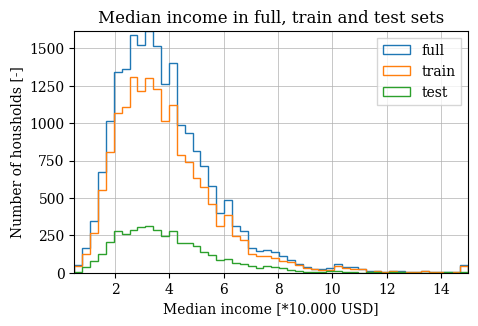

In [ ]:
plt.hist(housing.median_income  , bins = 50, histtype = 'step', label='full')
plt.hist(train_set.median_income, bins = 50, histtype = 'step', label='train')
plt.hist(test_set.median_income , bins = 50, histtype = 'step', label='test')
plt.legend()
plotlabels(plt.gca(), 'Median income in full, train and test sets', 'Median income [*10.000 USD]', 'Number of housholds [-]')

### Stratified sampling

Median income is said to be a very important predictor, thus we may need a stratified sampling.

 Ezt nevezzük rétegzett mintavételnek: a populációt homogén alcsoportokra, úgynevezett rétegekre osztjuk, és minden rétegből megfelelő számú példányt veszünk, hogy a tesztkészlet reprezentatív legyen a teljes populációra nézve. Fontos, hogy minden egyes réteghez elegendő számú példány legyen az adatállományban, különben a réteg fontosságának becslése torz lehet.

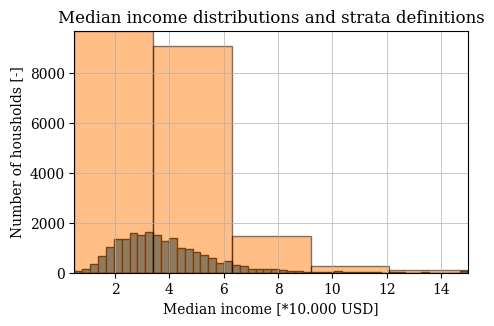

In [ ]:
plt.hist(housing.median_income, bins = 50, ec="k", label = '50 bins')
plt.hist(housing.median_income, bins = 5 , ec="k", label = '5 bins', alpha = 0.5)
plotlabels(plt.gca(), 'Median income distributions and strata definitions', 'Median income [*10.000 USD]', 'Number of housholds [-]')

In [ ]:
# add median income category to train_set dataset
# use pd.cut() to make a categorical attribute
housing["income_cat"] = pd.cut(housing["median_income"],
                                 bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                 labels=[1, 2, 3, 4, 5])

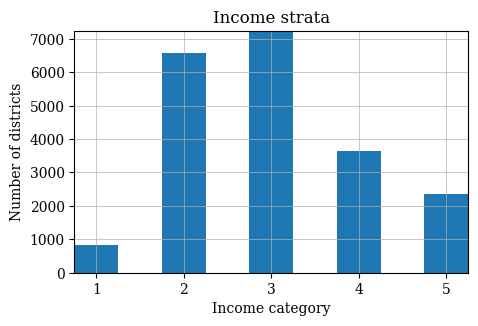

In [ ]:
housing.income_cat.value_counts().sort_index().plot.bar(rot=0, grid=True)
plotlabels(plt.gca(), 'Income strata', "Income category", "Number of districts")

In [ ]:
# 10 different stratified splits of the same dataset: (5 cat for 2 sets: test~ and train~)
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=rng)

strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

# # equivalently for a single stratified split:
# strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [ ]:
# print(len(strat_splits)) # tíz splitunk van
# print(strat_train_set_n.shape) # mindegyik train ugyanakkora
# print(strat_test_set_n.shape) # midnegyik test ugyanakkora

In [ ]:
# strat_splits[0]
# strat_splits[1]
# etc...

In [ ]:
# For now, we just use the first split:
strat_train_set, strat_test_set = strat_splits[0]

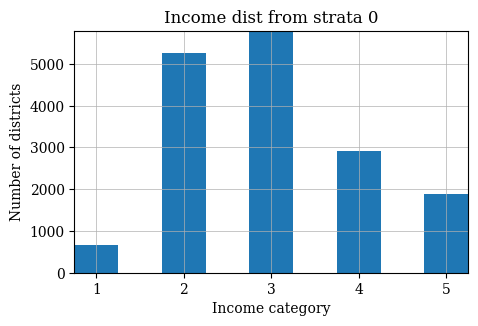

In [ ]:
strat_train_set.income_cat.value_counts().sort_index().plot.bar(rot=0, grid=True)
plotlabels(plt.gca(), 'Income dist from strata 0', "Income category", "Number of districts")

In [ ]:
# fig, ax = plt.subplots(1,2, figsize = (2*2.54*2, 2/1.618*2.54))

# for i in range(len(strat_splits)):
#     ax[0].hist(strat_splits[i][0]['income_cat'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], histtype = 'step')  # strat_splits[i][0] = train
#     ax[1].hist(strat_splits[i][1]['income_cat'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], histtype = 'step')  # strat_splits[i][1] test
# fig.suptitle('Comparing stratified sampling dsitribution of income categories in the train and test sets')
# plotlabels(ax[0], 'Train sets', "Income category", "Number of districts")
# plotlabels(ax[1], 'Test sets', "Income category", "Number of districts")

In [ ]:
# compare random and stratified sampling methods and witness, how stratified sampling is better to avoid sampling bias
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)  # random sampling
strat_train_set1, strat_test_set1 = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)  # strat. sampling

compare_props = pd.DataFrame({
    "Overall[%]": income_cat_proportions(housing),
    "Random[%]": income_cat_proportions(test_set),
    "Stratified[%]": income_cat_proportions(strat_test_set1)
}).sort_index()

compare_props.index.name = "Income Category"
compare_props["Rand.Error[%]"] = (compare_props["Random[%]"] / compare_props["Overall[%]"] - 1)
compare_props["Strat.Error[%]"] = (compare_props["Stratified[%]"] / compare_props["Overall[%]"] - 1)

(compare_props * 100).round(2)

,Overall[%],Random[%],Stratified[%],Rand.Error[%],Strat.Error[%]
Income Category,,,,,
1,3.98,4.24,4.00,6.45,0.36
2,31.88,30.74,31.88,-3.59,-0.02
3,35.06,34.52,35.05,-1.53,-0.01
4,17.63,18.41,17.64,4.42,0.03
5,11.44,12.09,11.43,5.63,-0.08


## 3. Explore and visualize the data to gain insights.

In [ ]:
# make a copy of the original so you can revert to it afterwards:

## history
## strat_train_set, strat_test_set = strat_splits[0], applied on housing

housing = strat_train_set.copy()

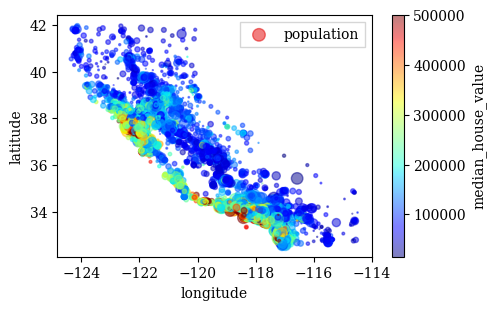

In [ ]:
# housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
# plt.show()

housing.plot(kind="scatter",
             x="longitude",
             y="latitude",
             s=housing["population"] / 100,
             label="population",
             c="median_house_value",
             cmap="jet",
             alpha=0.5,
             colorbar=True,
             legend=True)
plt.show()

house prices ~ popolation ~ location

<ipython-input-90-03904f8212b3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


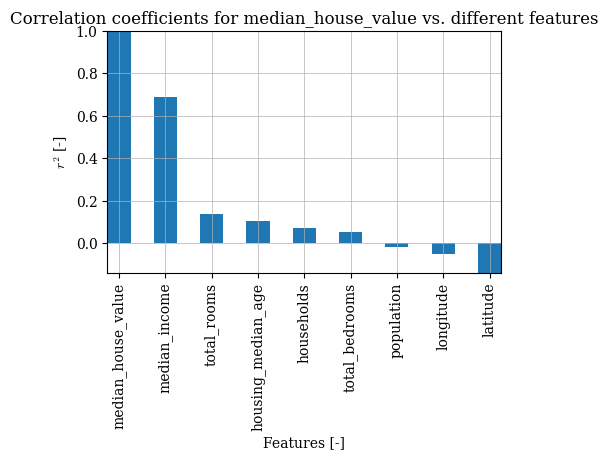

In [ ]:
corr_matrix = housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False).plot.bar(rot=90, grid=True)
plotlabels(plt.gca(), 'Correlation coefficients for median_house_value vs. different features', 'Features [-]', r'$r^2$ [-]')

In [ ]:
# from seaborn import heatmap
# heatmap(corr_matrix)

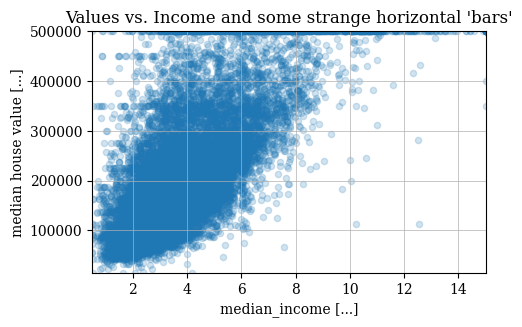

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2)
plotlabels(plt.gca(), "Values vs. Income and some strange horizontal 'bars'", 'median_income [...]', 'median house value [...]')
plt.show()
# plt.hexbin(housing.median_income, housing.median_house_value, gridsize=75, cmap='Blues')
# plt.show()

- positive correlation
- cap at 500.000
- strange horizontal lines at ~450, 350, 280 (you may want to get rid of such districts, otherwise the machine learns it)


### New features

In [ ]:
# Add new features:
housing['rooms_per_house'] = housing.total_rooms / housing.households
housing['bedrooms_ratio'] = housing.total_bedrooms / housing.total_rooms
housing['people_per_house'] = housing.population / housing.households

<ipython-input-94-03904f8212b3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


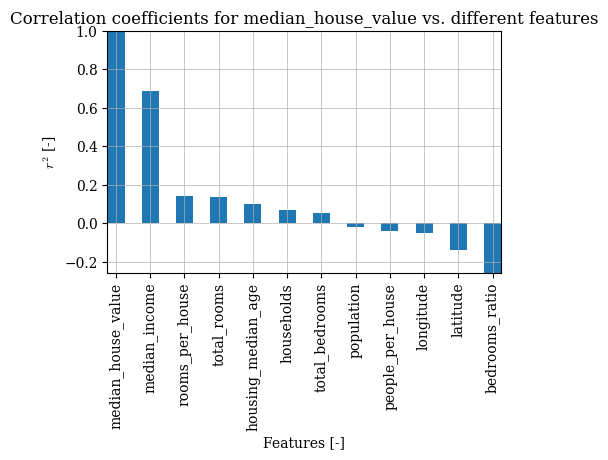

In [ ]:
corr_matrix = housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False).plot.bar(rot=90, grid=True)
plotlabels(plt.gca(), 'Correlation coefficients for median_house_value vs. different features', 'Features [-]', r'$r^2$ [-]')

## 4. Prepare the data for machine learning algorithms.


### Separate predictors and target

Let's revert to the original training set and separate the target (note that strat_train_set.drop() creates a copy of strat_train_set without the column, it doesn't actually modify strat_train_set itself, unless you pass inplace=True):


In [ ]:
# train_set (16512), test_set (4128)
# strat_splits (10), strat_train_set_n (16512), strat_test_set_n (4128)
# strat_train_set (16512), strat_test_set (4128) = strat_splits[0]
# housing = strat_train_set.copy()  # make a copy of the original so you can revert to it afterwards:

In [ ]:
# separate predictors and target:
housing = strat_train_set.drop("median_house_value", axis=1)  # does not modify the set unless, inplace=True
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY,2
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,5
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND,2
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,2
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,3
...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN,4
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND,2
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN,3
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN,3


In [ ]:
housing_labels

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
           ...   
14207    500001.0
13105     88800.0
19301    148800.0
19121    500001.0
19888    233300.0
Name: median_house_value, Length: 16512, dtype: float64

### Missing values
we use `housing_tr`

In [ ]:
# look for null values, not only in total_bedrooms, bc. it might comes handy later on
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND,3
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN,3
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN,3
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN,4
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN,5


In [ ]:
# drop rows with null value
"""
housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1
housing_option1.loc[null_rows_idx].head()
"""

'\nhousing_option1 = housing.copy()\nhousing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1\nhousing_option1.loc[null_rows_idx].head()\n'

In [ ]:
# drop the feauture with null value
"""
housing_option2 = housing.copy()
housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2
housing_option2.loc[null_rows_idx].head()
# also not a fancy a solution
"""

'\nhousing_option2 = housing.copy()\nhousing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2\nhousing_option2.loc[null_rows_idx].head()\n# also not a fancy a solution\n'

In [ ]:
# impute eg. the median value
"""
housing_option3 = housing.copy()
median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3
housing_option3.loc[null_rows_idx].head()
"""

'\nhousing_option3 = housing.copy()\nmedian = housing["total_bedrooms"].median()\nhousing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3\nhousing_option3.loc[null_rows_idx].head()\n'

In [ ]:
# use SimpleImputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")  # define the imputer strategy

housing_num = housing.select_dtypes(include=[np.number])  # select numeric columns
# non-numeric like ocean proximity comes later
imputer.fit(housing_num)  # utilise the imputer
imputer.statistics_  # check median values
housing_num.median().values  # Check that this is the same as manually computing the median of each attribute:

# Transform the training set:
X = imputer.transform(housing_num)
imputer.feature_names_in_

housing_tr = pd.DataFrame(X,
                          columns=housing_num.columns,
                          index=housing_num.index) # rebuild the dataframe

housing_tr.loc[null_rows_idx].head()  # check the filled values

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


*See also*

KNNImputer : Multivariate imputer that estimates missing features using nearest samples.

(KNNImputer replaces each missing value with the mean of the k-nearest neighbors’ values for that feature. The distance is based on all the available features.)

IterativeImputer : Multivariate imputer that estimates values to impute for each feature with missing values from all the others.

(IterativeImputer trains a regression model per feature to predict the missing values based on all the other available features. It then trains the model again on the updated data, and repeats the process several times, improving the models
and the replacement values at each iteration.)

### Outliers

<Axes: >

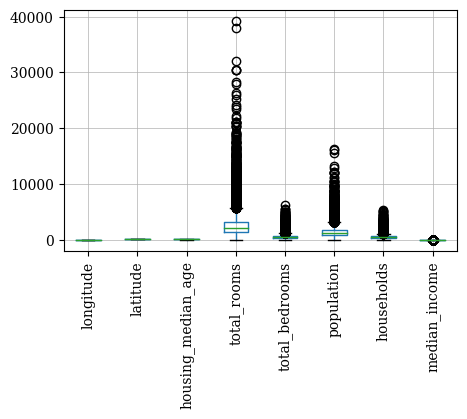

In [ ]:
housing.boxplot(rot=90, grid=True)

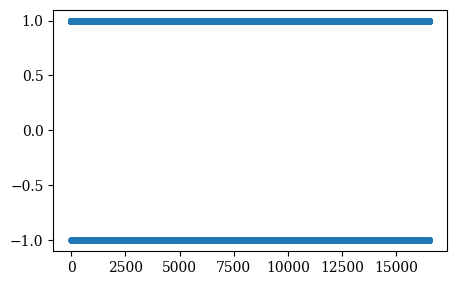

In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=rng)
# X = imputer.transform(housing_num) volt és ez a numerikus imputált adattábla
outlier_pred = isolation_forest.fit_predict(X)

plt.plot(outlier_pred, '.')

# If you wanted to drop outliers, you would run the following code:

#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

### Text and Categorical Attributes

we use `housing_cat `

In [ ]:
# ordinal encoding:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat = housing[["ocean_proximity"]]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

# check encoding results:
unique_values, counts =  np.unique(housing_cat_encoded, return_counts=True)

print(unique_values)
print(ordinal_encoder.categories_[0])
print(counts)

[0. 1. 2. 3. 4.]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
[7274 5301    2 1846 2089]


az a problema ezzel, hogy néhány ML az ordinális skalat közelségként is fel tudja fogni, pl.: 0-4 (<1H-NEAR) egymáshoz közelebb vannak, mint 0-1 (<1H-inland).
- Opció 1, vagy mi megadjuk a sorrendet;
- opció 2, szeparáljuk őket one-hot encoding módszerrel


In [ ]:
# one-hot encoding:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_onehot = cat_encoder.fit_transform(housing_cat)
housing_cat_onehot.toarray()
# new incoming data might consist for now unknown categories: cat_encoder.handle_unknown = "ignore"

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

### Scaling and transformation

**fit the scalers to the training data only**, Once you have a trained scaler, you can then use it to `transform()` any other set. Note if new data
contains outliers, these may end up scaled outside the range. If you want to avoid this, just set the `clip` hyperparameter to `True`.

General options for transformations:
- log
- square root, or power of something between [0 to 1]

General options for scaling:
- min-max
- standardization
- bucketizing, rough binning as in median income
- bucketizing using percentiles
- rbf_kernel: in case of 2 or more modes in the distribution, add a feature for each of the modes, representing the similarity between the housing median age and that particular mode. The similarity measure is typically computed using a radial basis function (RBF)—any function that depends only on the distance between the input value and a fixed point.

General options fro multimodal distributions (i.e., with two or more clear peaks, called modes):

- treating the bucket IDs as categories, rather than as numerical values. This means that the bucket indices must be encoded, for example using a
OneHotEncoder
- add a feature for each of the modes (at least the main ones), representing the similarity between the housing median age and that particular mode. The similarity measure is typically computed using a radial basis function (RBF)—any function that depends only on the distance between the input value and a fixed point. The most commonly used RBF is the Gaussian RBF...

transformation of heavy-tailed distributions

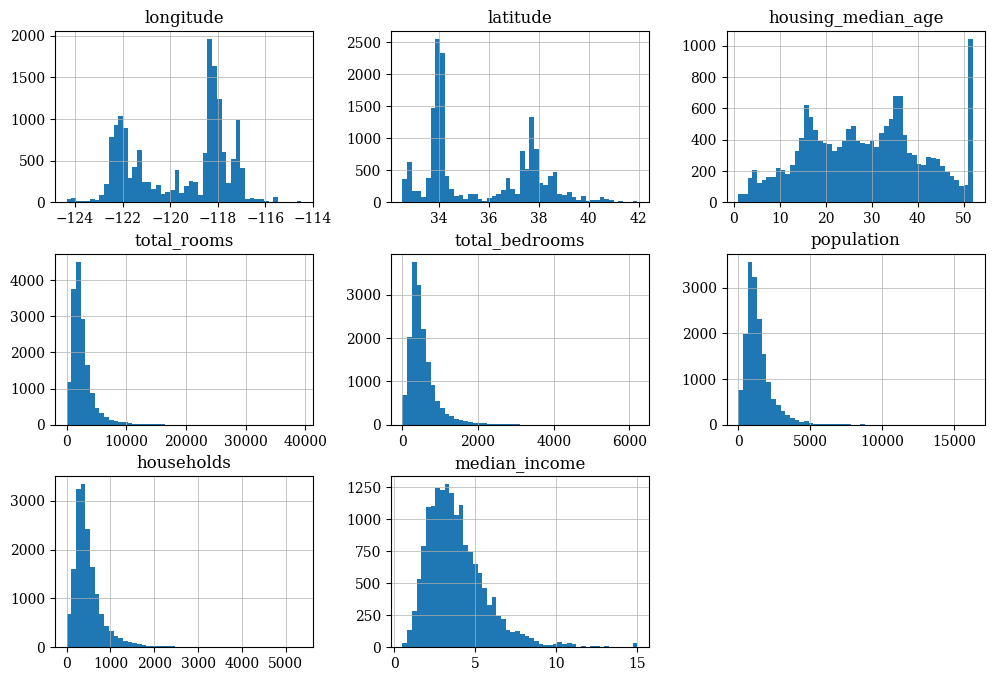

In [ ]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [ ]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [ ]:
# rbf_transformer = FunctionTransformer(rbf_kernel,
#                                       kw_args=dict(Y=[[35.]], gamma=0.1))
# age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [ ]:
# sf_coords = 37.7749, -122.41
# sf_transformer = FunctionTransformer(rbf_kernel,
#                                      kw_args=dict(Y=[sf_coords], gamma=0.1))
# sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [ ]:
# ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
# ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

### Transforming Multimodal distributions

here `housing_mdeian_age`



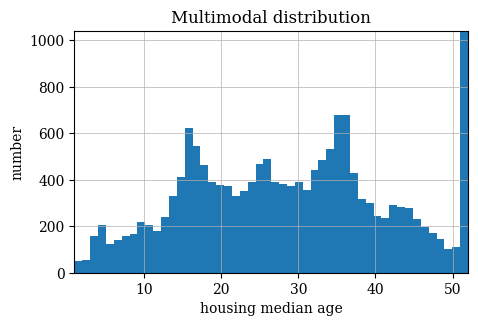

In [ ]:
plt.hist(housing.housing_median_age, bins = 50)
plotlabels(plt.gca(), 'Multimodal distribution', 'housing median age', 'number')

In [ ]:
bin_edges = np.linspace(0,
            max(housing.housing_median_age),
            int(max(housing.housing_median_age))+1)
bin_edges = np.append(bin_edges, np.inf)

In [ ]:
bin_width = bin_edges[1] / 2
bin_centers = bin_edges[0:-1] + bin_width

In [ ]:
counts, bin_e = np.histogram(housing.housing_median_age, bins = bin_edges)

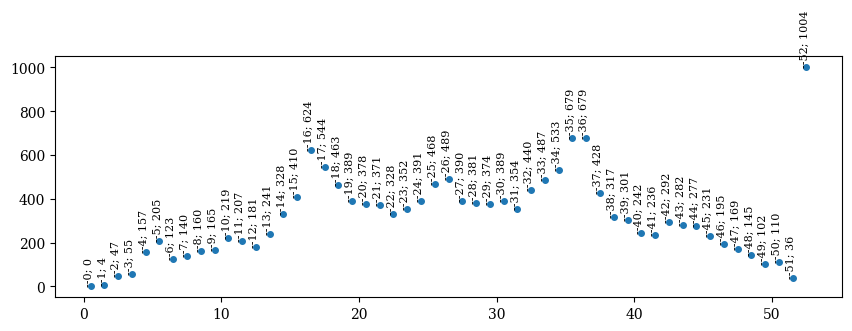

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (2*2*2.54, 2/1.618*2.54))
ax.plot(bin_centers, counts, '.')
for i in range(len(bin_centers)):
    ax.text(i, counts[i], '--' + str(i) + '; ' + str(counts[i]), rotation = 90, fontsize = 8, ha='left', va = 'bottom')

In [ ]:
modal_centers = [5, 17, 26, 35.5, 43, 52]

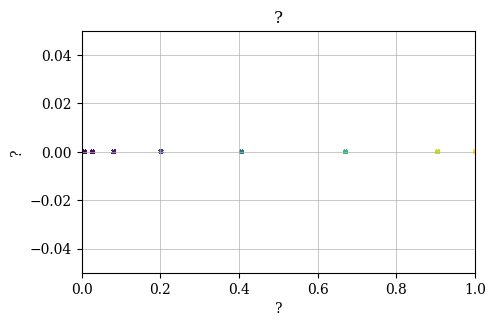

In [ ]:
# for 1 mode
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)
len(age_simil_35)  # 16512
plt.scatter(age_simil_35,np.zeros_like(age_simil_35), 5, marker = 'x', c = age_simil_35 )
plotlabels(plt.gca(), '?', '?', '?')

In [ ]:
# gamma = 0.1
# ages = np.linspace(housing["housing_median_age"].min(),
#                    housing["housing_median_age"].max(),
#                    500).reshape(-1, 1)
# rbf1 = rbf_kernel(ages, [[35.5]], gamma=gamma)

# fig, ax1 = plt.subplots()
# ax1.plot(bin_centers, counts, color = 'blue')
# ax1.tick_params(axis='y', labelcolor='blue')

# ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
# ax2.plot(ages, rbf1, color = 'orange',  label="gamma = 0.10")
# ax2.tick_params(axis='y', labelcolor='orange')

In [ ]:
gamma = 0.1
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)

rbfs = np.zeros([len(ages), len(modal_centers)])
k = 0
for i in modal_centers: # [5, 17, 26, 35.5, 52]
    rbfs[:,k] = rbf_kernel(ages, [[i]], gamma=gamma).ravel()
    k += 1

In [ ]:
# fig, ax1 = plt.subplots()

# ax1.plot(bin_centers, counts, color = 'blue')
# ax1.tick_params(axis='y', labelcolor='blue')

# ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
# ax2.tick_params(axis='y')
# for i in range(rbfs.shape[1]):
#     ax2.plot(ages, rbfs[:,i])

In [ ]:
modal_weights = np.array([200., 600., 500., 700., 300., 1000.])
modal_rel_weights = modal_weights / sum(modal_weights)
# modal_rel_weights

In [ ]:
rbfs_weighted = np.transpose(rbfs) * modal_rel_weights[:, np.newaxis]

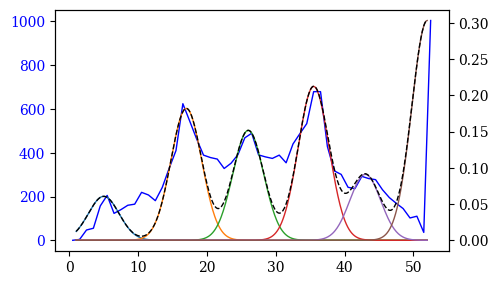

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(bin_centers, counts, color = 'blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
ax2.tick_params(axis='y')
for i in range(rbfs.shape[1]):
    ax2.plot(ages, rbfs_weighted[i,:])  # transpose miaatt i elso helyen

plt.plot(ages, np.sum(rbfs_weighted, axis = 0), 'k--')

In [ ]:
# find the indices of the local minima
from scipy.signal import argrelmin
minima_indices = argrelmin(np.sum(rbfs_weighted, axis = 0))
minima_indices

(array([ 93, 202, 289, 383, 446]),)

In [ ]:
minima_ages = ages[minima_indices]
minima_ages_list = np.insert(minima_ages, 0, 0)
minima_ages_list = np.append(minima_ages_list, np.inf)
print(minima_ages_list)

[ 0.         10.50501002 21.64529058 30.53707415 40.14428858 46.58316633
         inf]


In [ ]:
# use pd.cut() to make a categorical attribute
housing["housing_median_age_cat"] = pd.cut(housing["housing_median_age"],
                                 bins=minima_ages_list,
                                 labels=list(range(len(minima_ages_list)-1)))
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,housing_median_age_cat
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY,2,5
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,5,3
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND,2,3
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,2,1
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,3,3
...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN,4,4
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND,2,2
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN,3,1
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN,3,3


### Transforming Multimodal distributions using Kmeans

here `housing_mdeian_age`


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(-1.0, 2.0)

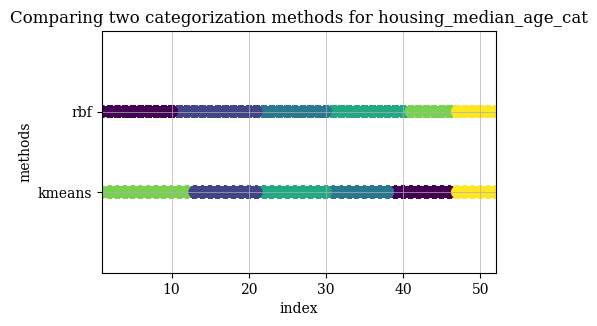

In [ ]:
from sklearn.cluster import KMeans

hma = np.array(housing["housing_median_age"])
hma = hma.reshape(-1, 1)
model = KMeans(n_clusters = 6, random_state = 42).fit(hma)
labels = model.labels_

plt.scatter(hma, np.zeros_like(hma), c=labels)
plt.scatter(hma, np.ones_like(hma), c = housing['housing_median_age_cat'])
plt.yticks([0,1], ['kmeans', 'rbf'])
plotlabels(plt.gca(),'Comparing two categorization methods for housing_median_age_cat', 'index', 'methods')
plt.ylim([-1,2])

In [ ]:
# add to df
housing["housing_median_age_cat2"] = model.labels_
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'income_cat', 'housing_median_age_cat',
       'housing_median_age_cat2'],
      dtype='object')

In [ ]:
# number of differences [%]
# not relevant, bc. indexing isn't necesserily the same
# sum(housing.housing_median_age_cat != housing.housing_median_age_cat2) / len(housing.housing_median_age_cat)*100

### GeoData

A custom transformer can  use other estimators. For example KMeans clusterer in the fit() method to identify the main clusters then rbf_kernel() in the transform() method to measure how
similar each sample is to each cluster center:

Here are a few things to note:
- The sklearn.utils.validation package contains several functions we can use
to validate the inputs. For simplicity, we will skip such tests in the rest of this
book, but production code should have them.
- Scikit-Learn pipelines require the fit() method to have two arguments X and y,
which is why we need the y=None argument even though we don’t use y.
- All Scikit-Learn estimators set n_features_in_ in the fit() method, and they
ensure that the data passed to transform() or predict() has this number of
features.
- The fit() method must return self.
- This implementation is not 100% complete: all estimators should set
feature_names_in_ in the fit() method when they are passed a DataFrame.
Moreover, all transformers should provide a get_feature_names_out() method,
as well as an inverse_transform() method when their transformation can be
reversed. See the last exercise at the end of this chapter for more details.

In [ ]:
# Importing necessary libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

# Creating a custom transformer class named ClusterSimilarity that inherits from BaseEstimator and TransformerMixin
class ClusterSimilarity(BaseEstimator, TransformerMixin):

    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):  #FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
        """
        Constructor for the ClusterSimilarity class.

        Parameters:
        - n_clusters: int, default=10
            The number of clusters to form using KMeans.
        - gamma: float, default=1.0
            Parameter for the radial basis function (RBF) kernel.
            - The RBF kernel is defined as follows:
                K(x, y) = exp(-gamma * ||x - y||^2)
            where:
                K(x, y) is the similarity between data points x and y after transformation using the RBF kernel.
                gamma is a hyperparameter that determines the spread of the kernel. It controls the influence of each data point on the similarity computation.
                ||x - y||^2 is the squared Euclidean distance between data points x and y.

            When gamma is small, the kernel has a wider spread, and each data point has a more significant
            influence on the similarity computation. As gamma increases, the kernel's spread becomes narrower,
            and data points have a localized influence on the similarity computation.
        - random_state: int or None, default=None
            Seed value for random number generation for reproducibility.
        """
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        """
        Fit the KMeans model on the input data X and optional sample weights.

        Parameters:
        - X: array-like or pd.DataFrame
            The input data to fit the KMeans model on.
        - y: array-like or None, default=None
            The target values (ignored in this case).
        - sample_weight: array-like or None, default=None
            Individual weights for each sample (optional).

        Returns:
        - self: ClusterSimilarity instance
            The fitted ClusterSimilarity instance.
        """
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # The fit() method must return self.

    def transform(self, X):
        """
        Transform the input data X using the radial basis function (RBF) kernel with cluster centers.

        Parameters:
        - X: array-like or pd.DataFrame
            The input data to transform.

        Returns:
        - transformed_data: array-like
            The transformed data using the RBF kernel.
        """
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None): # all transformers should provide a get_feature_names_out() method,
        """
        Get the output feature names for the transformed data.

        Parameters:
        - names: array-like or None, default=None
            Not used in this case (optional).

        Returns:
        - feature_names: list of str
            A list of feature names for each cluster's similarity.
        """
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
cluster_simil_10 = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil_10.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)
# This code creates a ClusterSimilarity transformer, setting the number of clusters to 10.
# Then it calls fit_transform() with the latitude and longitude of every district in the training set,
# weighting each district by its median house value.
# The transformer uses k-means to locate the clusters,
# then measures the Gaussian RBF similaritybetween each district and all 10 cluster centers.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
cluster_simil_10

ClusterSimilarity(random_state=42)

In [ ]:
cluster_simil_10.kmeans_

KMeans(n_clusters=10, random_state=42)

In [ ]:
cluster_simil_10.kmeans_.cluster_centers_

array([[  33.84807612, -117.76264178],
       [  37.79339173, -121.02020116],
       [  34.05401714, -118.32417903],
       [  36.64651014, -119.5667933 ],
       [  40.22071398, -123.06364765],
       [  38.86476363, -121.2349362 ],
       [  32.93618777, -117.03359137],
       [  37.88199464, -122.33783088],
       [  34.69806089, -119.75396145],
       [  37.26057373, -121.95821379]])

In [ ]:
cluster_simil_10.kmeans_.cluster_centers_[:, 1] # long coordinates (x)

array([-117.76264178, -121.02020116, -118.32417903, -119.5667933 ,
       -123.06364765, -121.2349362 , -117.03359137, -122.33783088,
       -119.75396145, -121.95821379])

In [ ]:
cluster_simil_10.kmeans_.cluster_centers_[:, 0] # lat coordinates (y)

array([33.84807612, 37.79339173, 34.05401714, 36.64651014, 40.22071398,
       38.86476363, 32.93618777, 37.88199464, 34.69806089, 37.26057373])

In [ ]:
# The result is a matrix with one row per district, and one column per cluster.
# Let’s look at the first three rows, rounding to two decimal places:

similarities.shape  # districts (each instance, rows) X clusters (10 cluster)

(16512, 10)

In [ ]:
similarities[0,:]  # tagsági függvény az első instance-hez
similarities[0,:].round(2)

array([0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ])

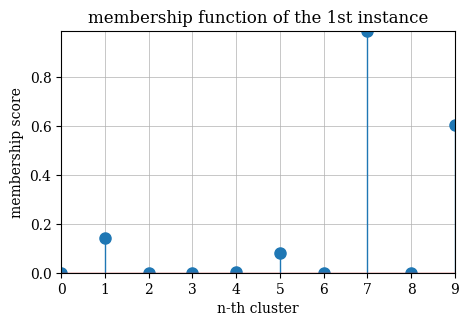

In [ ]:
plt.stem(similarities[0,:])
plotlabels(plt.gca(),'membership function of the 1st instance','n-th cluster','membership score')

In [ ]:
# megkeressük mindegyik sor esetében, hogy melyik clusterben a legnagyobb a tagsága
max_cluster_similarity = similarities.max(axis=1)
max_cluster_similarity.shape

(16512,)

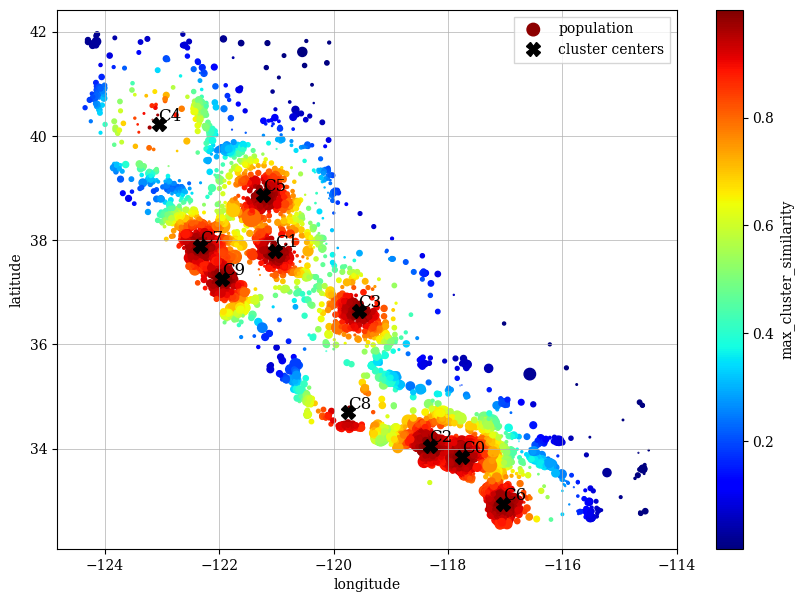

In [ ]:
housing["max_cluster_similarity"] = max_cluster_similarity

housing.plot(kind="scatter",
             x="longitude",
             y="latitude",
             grid=True,
             s=housing["population"] / 100,
             label="population",
             c="max_cluster_similarity",
             cmap="jet",
             colorbar=True,
             legend=True,
             sharex=False,
             figsize=(10, 7))

plt.plot(cluster_simil_10.kmeans_.cluster_centers_[:, 1],
         cluster_simil_10.kmeans_.cluster_centers_[:, 0],
         linestyle="",
         color="black",
         marker="X",
         markersize=10,
         label="cluster centers")

# Add text with cluster IDs to the plot
for cluster_id, (x, y) in enumerate(cluster_simil_10.kmeans_.cluster_centers_):
    plt.text(y, x, f"C{cluster_id}", fontsize=12, ha='left', va='bottom')

plt.legend(loc="upper right")
plt.show()

## Transformation Pipelines

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer.
ColumnTransformer for num_pipeline & cat_pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

In [ ]:
# num_pipeline = Pipeline([
#     ("imputer",      SimpleImputer(strategy="median")),
#     ("standardizer", StandardScaler()),
# ])

# num_pipeline

In [ ]:
# see and check
# housing_num_prepared = num_pipeline.fit_transform(housing_num)
# housing_num_prepared[:2].round(2)

In [ ]:
# if you want to recover a dataframe:
# housing_num_prepared_df = pd.DataFrame(
#     housing_num_prepared,
#     columns=num_pipeline.get_feature_names_out(),
#     index=housing_num.index)

# housing_num_prepared_df

In [ ]:
# cat_pipeline = Pipeline([
#     ("imputer",     SimpleImputer(strategy="most_frequent")),
#     ("encoder",     OneHotEncoder(handle_unknown="ignore")),
# ])
# cat_pipeline

In [ ]:
from sklearn.compose import ColumnTransformer

# num_attribs = ["longitude",
#                "latitude",
#                "housing_median_age",
#                "total_rooms",
#                "total_bedrooms",
#                "population",
#                "households",
#                "median_income"]

# cat_attribs = ["ocean_proximity"]

# preprocessing = ColumnTransformer([
#     ("num", num_pipeline, num_attribs),
#     ("cat", cat_pipeline, cat_attribs),
# ])

# preprocessing

In [ ]:
# housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
## if you want to recover a dataframe:
# housing_prepared_df = pd.DataFrame(
#     housing_prepared,
#     columns = preprocessing.get_feature_names_out(),
#     index = housing_num.index)

put it all together

In [ ]:
def column_ratio(X):  # to FunctionTransformer
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):  # to FunctionTransformer
    return ["logratio"] # feature names out

def log_ratio_pipeline():
    return Pipeline([
        ('imputer',     SimpleImputer(strategy="median")),
        ('transformer', FunctionTransformer(column_ratio, feature_names_out=ratio_name)),
        ('logger',      FunctionTransformer(np.log, feature_names_out = log_name)),
        ('scaler',      StandardScaler())
    ])

In [ ]:
def log_name(function_transformer, feature_names_in):  # to FunctionTransformer
    string = []
    for i in feature_names_in:
        string.append(i)
    return string

log_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('logger',  FunctionTransformer(np.log, feature_names_out = log_name)),
    ('scaler',  StandardScaler())
    ])

In [ ]:
cat_pipeline = Pipeline([
    ("imputer",  SimpleImputer(strategy="most_frequent")),
    ("encoder",  OneHotEncoder(handle_unknown="ignore")),
])

In [ ]:
# cluster_simil_10 = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

geo = Pipeline([
    ("geo_kmeans", cluster_simil_10, ["latitude", "longitude"])
    ])

In [ ]:
cluster_simil_5 = ClusterSimilarity(n_clusters=5, gamma=1., random_state=42)

age_pipeline = Pipeline([
    ("age_kmeans", cluster_simil_5, ["housing_median_age"]),
])

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer([
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population","households", "median_income"]),
    ("bedrooms", log_ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", log_ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", log_ratio_pipeline(), ["population", "households"]),
    ("geo", cluster_simil_10, ["latitude", "longitude"]),  # ide nem kell (), pl: geo_pipeline()
    ("cat", cat_pipeline, ["ocean_proximity"]),
    ('age', cluster_simil_5, ['housing_median_age'])
])

preprocessing

ColumnTransformer(transformers=[('log',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('logger',
                                                  FunctionTransformer(feature_names_out=<function log_name at 0x7a630bd270a0>,
                                                                      func=<ufunc 'log'>)),
                                                 ('scaler', StandardScaler())]),
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('bedrooms',
                                 Pipeline(steps=[('imputer',
                                                  Si...
                                                 ('scaler', StandardScaler())]),
                                 ['population', 'households']),
                                ('geo', ClusterSimilarity(random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ocean_proximity']),
                                ('age',
                                 ClusterSimilarity(n_clusters=5,
                                                   random_state=42),
                                 ['housing_median_age'])])

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
housing_prepared

array([[ 1.32411352e+000,  6.37892095e-001,  4.56906246e-001, ...,
         6.07760913e-274,  0.00000000e+000,  1.18483415e-114],
       [-2.52670774e-001, -6.35755068e-002, -7.11654159e-001, ...,
         4.74329984e-075,  0.00000000e+000,  2.24894426e-008],
       [-9.25266390e-001, -8.59927213e-001, -9.41997266e-001, ...,
         8.61887752e-017,  1.20649717e-275,  3.85922342e-004],
       ...,
       [ 8.24206237e-001,  8.59552146e-001,  1.24338084e+000, ...,
         7.44344035e-085,  2.73441513e-012,  1.46592511e-226],
       [ 9.87850968e-001,  8.11292914e-001,  5.79462261e-001, ...,
         7.17655216e-045,  0.00000000e+000,  2.38950139e-001],
       [-1.07217904e+000, -2.09154331e+000, -6.79447241e-001, ...,
         1.88822928e-127,  0.00000000e+000,  6.65725311e-030]])

In [ ]:
# recover a dataframe:
housing_prepared = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing_num.index)

housing_prepared.columns

Index(['log__total_bedrooms', 'log__total_rooms', 'log__population',
       'log__households', 'log__median_income', 'bedrooms__logratio',
       'rooms_per_house__logratio', 'people_per_house__logratio',
       'geo__Cluster 0 similarity', 'geo__Cluster 1 similarity',
       'geo__Cluster 2 similarity', 'geo__Cluster 3 similarity',
       'geo__Cluster 4 similarity', 'geo__Cluster 5 similarity',
       'geo__Cluster 6 similarity', 'geo__Cluster 7 similarity',
       'geo__Cluster 8 similarity', 'geo__Cluster 9 similarity',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'age__Cluster 0 similarity',
       'age__Cluster 1 similarity', 'age__Cluster 2 similarity',
       'age__Cluster 3 similarity', 'age__Cluster 4 similarity'],
      dtype='object')

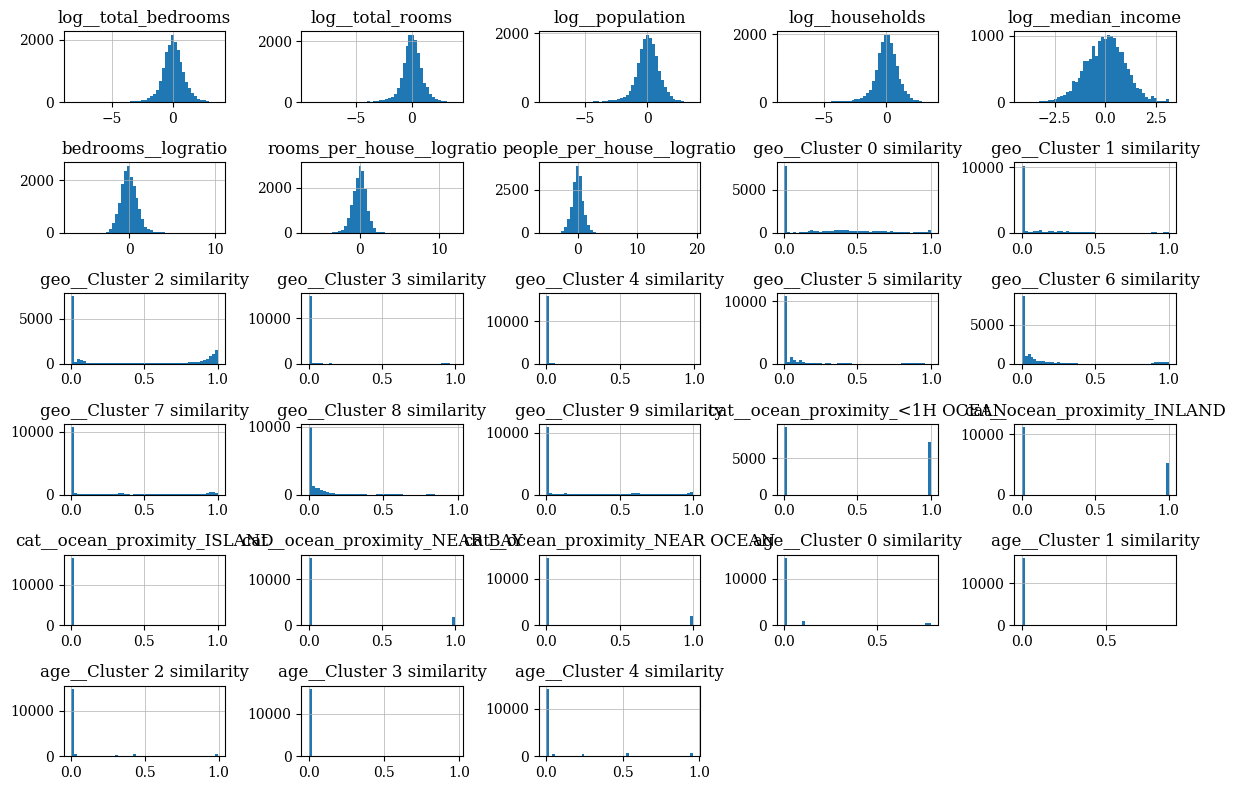

In [ ]:
housing_prepared.hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

## 5. Select a model and train it.

In [ ]:
# előzmények
# train_set (16512), test_set (4128)
# strat_splits (10), strat_train_set_n (16512), strat_test_set_n (4128)
# strat_train_set (16512), strat_test_set (4128) = strat_splits[0]
# housing = strat_train_set.copy()  # make a copy of the original so you can revert to it afterwards:

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)

In [ ]:
# quick check first few elements
print(housing_predictions[:5].round(0))
print(housing_labels.iloc[:5].values)
print(housing_predictions[:5].round(0) - housing_labels.iloc[:5].values)

[229530. 369978. 133146.  88730. 304794.]
[458300. 483800. 101700.  96100. 361800.]
[-228770. -113822.   31446.   -7370.  -57006.]


In [ ]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)
lin_rmse.round(0)

69604.0

lin_reg underfitted

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state = 42)
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)

In [ ]:
# quick check first few elements
print(housing_predictions[:5].round(0))
print(housing_labels.iloc[:5].values)
print(housing_predictions[:5].round(0) - housing_labels.iloc[:5].values)

[458300. 483800. 101700.  96100. 361800.]
[458300. 483800. 101700.  96100. 361800.]
[0. 0. 0. 0. 0.]


In [ ]:
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)
lin_rmse

0.0

tree_reg overfitted

In [ ]:
from sklearn.model_selection import cross_val_score

tree_lin_rmse_scores = (-1*cross_val_score(tree_reg,
                                       housing_prepared,
                                       housing_labels,
                                       scoring = 'neg_root_mean_squared_error', # this is a utility function, hence -1*()
                                       cv = 10))

print(tree_lin_rmse_scores.round(0))
print(np.mean(tree_lin_rmse_scores).round(0))
print(np.std(tree_lin_rmse_scores).round(0))

[68325. 61714. 67310. 67119. 68208. 67726. 66960. 69268. 67227. 64460.]
66832.0
2078.0


tree_reg is as bad as lin_reg

Elég lassú lesz...

In [ ]:
if do_you_have_time == 'y':
    from sklearn.ensemble import RandomForestRegressor

    forest_reg = RandomForestRegressor(random_state=42)
    forest_reg.fit(housing_prepared, housing_labels)
    forest_rmses = -cross_val_score(forest_reg,
                                    housing_prepared,
                                    housing_labels,
                                    scoring = 'neg_root_mean_squared_error',
                                    cv = 5)

    print(forest_rmses.round(0))
    print(np.mean(forest_rmses).round(0))
    print(np.std(forest_rmses).round(0))

[47589. 46709. 48117. 48407. 47144.]
47593.0
620.0


## 6. Fine-tune your model.


#### Grid Search with Cross Validation

introductory example for linear regression (with no hyperparems),
where the number of geo-clusters will searched through

In [ ]:
from sklearn.model_selection import GridSearchCV


# worth to make pipeline for fine-tuning
full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('linear_model', lin_reg)
])

# setup any hyperparameter here
parameter_grid = [
    {'preprocessing__geo__n_clusters' : [5,10,20]},
    {'preprocessing__age__n_clusters' : [5,10,20]}
]

# cosntruct
grid_search = GridSearchCV(full_pipeline,
                           parameter_grid,
                           scoring = 'neg_root_mean_squared_error',
                           cv = 3)  # 3-fold cross validation

# search
grid_search.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('log',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('logger',
                                                                                          FunctionTransformer(feature_names_out=<function log_name at 0x7a630bd270a0>,
                                                                                                              func=<ufunc 'log'>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['total_bedrooms',
                                                                          'total_rooms',
                                                                          'population',
                                                                          'households...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ocean_proximity']),
                                                                        ('age',
                                                                         ClusterSimilarity(n_clusters=5,
                                                                                           random_state=42),
                                                                         ['housing_median_age'])])),
                                       ('linear_model', LinearRegression())]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 10, 20]},
                         {'preprocessing__age__n_clusters': [5, 10, 20]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([1.05047456, 1.29266961, 1.48248863, 0.88133915, 0.91204317,
        1.11208646]),
 'std_fit_time': array([0.15136168, 0.32094425, 0.56301542, 0.09573376, 0.09218044,
        0.18116306]),
 'mean_score_time': array([0.03175831, 0.03397799, 0.03882996, 0.0362529 , 0.03274218,
        0.03997954]),
 'std_score_time': array([0.0021416 , 0.00418641, 0.00825809, 0.00262892, 0.00144866,
        0.00182262]),
 'param_preprocessing__geo__n_clusters': masked_array(data=[5, 10, 20, --, --, --],
              mask=[False, False, False,  True,  True,  True],
        fill_value='?',
             dtype=object),
 'param_preprocessing__age__n_clusters': masked_array(data=[--, --, --, 5, 10, 20],
              mask=[ True,  True,  True, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'preprocessing__geo__n_clusters': 5},
  {'preprocessing__geo__n_clusters': 10},
  {'preprocessing__geo__n_clusters': 20},
  {'preprocessing__age__n_clusters': 

In [ ]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 20}

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_preprocessing__geo__n_clusters',
       'param_preprocessing__age__n_clusters', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [ ]:
print(cv_results["param_preprocessing__geo__n_clusters"])
print('')
print(cv_results["param_preprocessing__age__n_clusters"])

2     20
5    NaN
4    NaN
1     10
3    NaN
0      5
Name: param_preprocessing__geo__n_clusters, dtype: object

2    NaN
5     20
4     10
1    NaN
3      5
0    NaN
Name: param_preprocessing__age__n_clusters, dtype: object


In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values(by="mean_test_score", ascending=False, inplace=True)

# change column names to fit on this page, and show rmse = -score :
cv_results = cv_results[["param_preprocessing__geo__n_clusters",
                         "param_preprocessing__age__n_clusters",
                         "params",
                         "split0_test_score",
                         "split1_test_score",
                         "split2_test_score",
                         "mean_test_score",
                         "std_test_score"]]

score_cols = ["split0_test_score", "split1_test_score", "split2_test_score", "mean_test_score"]
# cv_results.columns = ["n_clusters"] + score_cols
cv_results[score_cols] = -cv_results[score_cols].round().astype(np.int64)
cv_results["std_test_score"] = cv_results["std_test_score"].round().astype(np.int64)

cv_results.head() # note: the 1st column is the row ID

,param_preprocessing__geo__n_clusters,param_preprocessing__age__n_clusters,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
2,20,NaN,{'preprocessing__geo__n_clusters': 20},68203,68605,69910,68906,729
5,NaN,20,{'preprocessing__age__n_clusters': 20},68082,68911,70224,69072,882
4,NaN,10,{'preprocessing__age__n_clusters': 10},68039,68994,70274,69102,916
1,10,NaN,{'preprocessing__geo__n_clusters': 10},68765,69673,70984,69807,911
3,NaN,5,{'preprocessing__age__n_clusters': 5},68765,69673,70984,69807,911


introductory example for random_forest,
where the number of geo-clusters will searched through

nagyon nagyon lassu lesz

In [ ]:
if do_you_have_time == 'y':

    from sklearn.ensemble import RandomForestRegressor

    full_pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("random_forest", RandomForestRegressor(random_state=42)),
    ])
    param_grid = [
        {'preprocessing__geo__n_clusters': [5, 20],
        'random_forest__max_features': [4, 16]},
        {'preprocessing__geo__n_clusters': [10, 15],
        'random_forest__max_features': [6, 8, 10]},

        {'preprocessing__age__n_clusters': [5, 20],
        'random_forest__max_features': [4, 16]},
        {'preprocessing__age__n_clusters': [10, 15],
        'random_forest__max_features': [6, 8, 10]},
    ]
    grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
    scoring='neg_root_mean_squared_error')
    grid_search.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values(by="mean_test_score", ascending=False, inplace=True)

# change column names to fit on this page, and show rmse = -score :
cv_results = cv_results[["param_preprocessing__geo__n_clusters",
                         "param_preprocessing__age__n_clusters",
                         "params",
                         "split0_test_score",
                         "split1_test_score",
                         "split2_test_score",
                         "mean_test_score",
                         "std_test_score"]]

score_cols = ["split0_test_score", "split1_test_score", "split2_test_score", "mean_test_score"]
# cv_results.columns = ["n_clusters"] + score_cols
cv_results[score_cols] = -cv_results[score_cols].round().astype(np.int64)
cv_results["std_test_score"] = cv_results["std_test_score"].round().astype(np.int64)

cv_results.head() # note: the 1st column is the row ID

,param_preprocessing__geo__n_clusters,param_preprocessing__age__n_clusters,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
2,20,NaN,"{'preprocessing__geo__n_clusters': 20, 'random...",43082,43842,44498,43808,579
7,15,NaN,"{'preprocessing__geo__n_clusters': 15, 'random...",43417,43949,44988,44118,652
8,15,NaN,"{'preprocessing__geo__n_clusters': 15, 'random...",43849,44205,45279,44444,608
9,15,NaN,"{'preprocessing__geo__n_clusters': 15, 'random...",44089,44586,45177,44617,445
3,20,NaN,"{'preprocessing__geo__n_clusters': 20, 'random...",44512,45062,45247,44940,312


In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values(by="mean_test_score", ascending=False, inplace=True)

# change column names to fit on this page, and show rmse = -score :
cv_results = cv_results[["param_preprocessing__geo__n_clusters",
                         "param_preprocessing__age__n_clusters",
                         "params",
                         "split0_test_score",
                         "split1_test_score",
                         "split2_test_score",
                         "mean_test_score",
                         "std_test_score"]]

score_cols = ["split0_test_score", "split1_test_score", "split2_test_score", "mean_test_score"]
# cv_results.columns = ["n_clusters"] + score_cols
cv_results[score_cols] = -cv_results[score_cols].round().astype(np.int64)

cv_results.head() # note: the 1st column is the row ID

,param_preprocessing__geo__n_clusters,param_preprocessing__age__n_clusters,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
2,20,NaN,"{'preprocessing__geo__n_clusters': 20, 'random...",43082,43842,44498,43808,578.657794
7,15,NaN,"{'preprocessing__geo__n_clusters': 15, 'random...",43417,43949,44988,44118,652.260001
8,15,NaN,"{'preprocessing__geo__n_clusters': 15, 'random...",43849,44205,45279,44444,607.849392
9,15,NaN,"{'preprocessing__geo__n_clusters': 15, 'random...",44089,44586,45177,44617,444.947266
3,20,NaN,"{'preprocessing__geo__n_clusters': 20, 'random...",44512,45062,45247,44940,312.141368


In [ ]:
cv_results

,param_preprocessing__geo__n_clusters,param_preprocessing__age__n_clusters,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
2,20,NaN,"{'preprocessing__geo__n_clusters': 20, 'random...",43082,43842,44498,43808,578.657794
7,15,NaN,"{'preprocessing__geo__n_clusters': 15, 'random...",43417,43949,44988,44118,652.260001
8,15,NaN,"{'preprocessing__geo__n_clusters': 15, 'random...",43849,44205,45279,44444,607.849392
9,15,NaN,"{'preprocessing__geo__n_clusters': 15, 'random...",44089,44586,45177,44617,444.947266
3,20,NaN,"{'preprocessing__geo__n_clusters': 20, 'random...",44512,45062,45247,44940,312.141368
15,NaN,10,"{'preprocessing__age__n_clusters': 10, 'random...",44716,45074,46089,45293,581.746474
4,10,NaN,"{'preprocessing__geo__n_clusters': 10, 'random...",44798,45213,46084,45365,535.824628
18,NaN,15,"{'preprocessing__age__n_clusters': 15, 'random...",45138,44994,46162,45431,520.184883
19,NaN,15,"{'preprocessing__age__n_clusters': 15, 'random...",44920,45118,46344,45460,629.924984
14,NaN,10,"{'preprocessing__age__n_clusters': 10, 'random...",45081,45183,46233,45499,520.836461


## Randomized search


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'preprocessing__age__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features':    randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_distribs,
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42)

rnd_search.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('log',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('logger',
                                                                                                FunctionTransformer(feature_names_out=<function log_name at 0x7a630bd270a0>,
                                                                                                                    func=<ufunc 'log'>)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['total_bedrooms',
                                                                                'total_rooms',
                                                                                'population',
                                                                                'hous...
                   param_distributions={'preprocessing__age__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a630b201ed0>,
                                        'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a630b246e90>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a630b246f20>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
# Analyze the Best Models and Their Errors

# Feature Importances incl. preprocessing
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.01, 0.01, 0.01, 0.01, 0.22, 0.06, 0.06, 0.06, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.01, 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.04, 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.  , 0.01, 0.01, 0.01, 0.  , 0.02, 0.01, 0.02, 0.  , 0.09, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.21855261875295776, 'log__median_income'),
 (0.0920987839577911, 'cat__ocean_proximity_INLAND'),
 (0.05916981612182647, 'people_per_house__logratio'),
 (0.05845238483331844, 'rooms_per_house__logratio'),
 (0.05668218866842299, 'bedrooms__logratio'),
 (0.04065509054217652, 'geo__Cluster 28 similarity'),
 (0.029081521226548408, 'geo__Cluster 18 similarity'),
 (0.023526836591645568, 'geo__Cluster 17 similarity'),
 (0.02112850384501643, 'geo__Cluster 43 similarity'),
 (0.017698292275084983, 'geo__Cluster 3 similarity'),
 (0.015462452133662201, 'geo__Cluster 41 similarity'),
 (0.01361304078723588, 'geo__Cluster 15 similarity'),
 (0.011796284282389753, 'geo__Cluster 8 similarity'),
 (0.011208816367020891, 'geo__Cluster 37 similarity'),
 (0.011079307437820835, 'geo__Cluster 10 similarity'),
 (0.010972108807767928, 'geo__Cluster 21 similarity'),
 (0.010889158795551829, 'geo__Cluster 38 similarity'),
 (0.010887451472523412, 'geo__Cluster 34 similarity'),
 (0.010696045034682201, 'geo__Cluster

    [(0.21855261875295776, 'log__median_income'),
    (0.0920987839577911, 'cat__ocean_proximity_INLAND'),
    (0.05916981612182647, 'people_per_house__logratio'),
    (0.05845238483331844, 'rooms_per_house__logratio'),
    (0.05668218866842299, 'bedrooms__logratio'),
    (0.04065509054217652, 'geo__Cluster 28 similarity'),
    (0.029081521226548408, 'geo__Cluster 18 similarity'),
    (0.023526836591645568, 'geo__Cluster 17 similarity'),
    (0.02112850384501643, 'geo__Cluster 43 similarity'),
    (0.017698292275084983, 'geo__Cluster 3 similarity'),
    (0.015462452133662201, 'geo__Cluster 41 similarity'),
    (0.01361304078723588, 'geo__Cluster 15 similarity'),
    (0.011796284282389753, 'geo__Cluster 8 similarity'),
    (0.011208816367020891, 'geo__Cluster 37 similarity'),
    (0.011079307437820835, 'geo__Cluster 10 similarity'),
    (0.010972108807767928, 'geo__Cluster 21 similarity'),
    (0.010889158795551829, 'geo__Cluster 38 similarity'),
    (0.010887451472523412, 'geo__Cluster 34 similarity'),
    (0.010696045034682201, 'geo__Cluster 1 similarity'),
    (0.010504148819905475, 'geo__Cluster 35 similarity'),
    (0.010386254934004854, 'geo__Cluster 5 similarity'),
    (0.010228762258978098, 'geo__Cluster 39 similarity'),
    (0.009732238605877238, 'geo__Cluster 24 similarity'),
    (0.009489343661961882, 'geo__Cluster 25 similarity'),
    (0.009202386022381367, 'geo__Cluster 33 similarity'),
    (0.008939208571444876, 'geo__Cluster 2 similarity'),
    (0.00878032797262505, 'geo__Cluster 14 similarity'),
    (0.008651814256644179, 'geo__Cluster 31 similarity'),
    (0.008489221007701716, 'geo__Cluster 42 similarity'),
    (0.008397418751679625, 'geo__Cluster 27 similarity'),
    (0.007579710721643742, 'geo__Cluster 4 similarity'),
    (0.007523201488265028, 'geo__Cluster 19 similarity'),
    (0.007501835397257149, 'geo__Cluster 20 similarity'),
    (0.0072768155898016796, 'geo__Cluster 22 similarity'),
    (0.006955703286966832, 'geo__Cluster 26 similarity'),
    (0.006900708725950906, 'geo__Cluster 32 similarity'),
    (0.006886701351807711, 'geo__Cluster 13 similarity'),
    (0.006858385779662211, 'geo__Cluster 11 similarity'),
    (0.006759398379586677, 'geo__Cluster 16 similarity'),
    (0.006492787395092884, 'log__total_rooms'),
    (0.006451473481316905, 'geo__Cluster 23 similarity'),
    (0.006169164748013396, 'log__population'),
    (0.0059104060403352785, 'log__total_bedrooms'),
    (0.0058801580703988394, 'geo__Cluster 30 similarity'),
    (0.005816585409113951, 'log__households'),
    (0.005568123116277661, 'geo__Cluster 9 similarity'),
    (0.005184266759995406, 'geo__Cluster 0 similarity'),
    (0.004648268973027514, 'geo__Cluster 40 similarity'),
    (0.0045262400083262355, 'geo__Cluster 12 similarity'),
    (0.004260642099081692, 'geo__Cluster 29 similarity'),
    (0.004197640258852215, 'geo__Cluster 36 similarity'),
    (0.003991131108814891, 'geo__Cluster 7 similarity'),
    (0.003680388073192203, 'cat__ocean_proximity_<1H OCEAN'),
    (0.002530524177866332, 'geo__Cluster 6 similarity'),
    (0.0018979619881008358, 'cat__ocean_proximity_NEAR OCEAN'),
    (0.0015452854751058648, 'age__Cluster 0 similarity'),
    (0.0013914958741431563, 'age__Cluster 1 similarity'),
    (0.0013812229424899052, 'age__Cluster 8 similarity'),
    (0.0013753634084319587, 'age__Cluster 20 similarity'),
    (0.0013715878027083992, 'age__Cluster 13 similarity'),
    (0.0013236897690684449, 'age__Cluster 26 similarity'),
    (0.001310737946466828, 'age__Cluster 18 similarity'),
    (0.001299226497432357, 'age__Cluster 24 similarity'),
    (0.0012865716527501617, 'age__Cluster 27 similarity'),
    (0.0012053241926312098, 'age__Cluster 3 similarity'),
    (0.0011750360412248158, 'age__Cluster 14 similarity'),
    (0.0011262285150611278, 'age__Cluster 9 similarity'),
    (0.0011189290431156025, 'age__Cluster 19 similarity'),
    (0.001098646046334607, 'age__Cluster 10 similarity'),
    (0.0010223976447833983, 'age__Cluster 21 similarity'),
    (0.0010171041288096234, 'age__Cluster 2 similarity'),
    (0.0009938158856594248, 'age__Cluster 23 similarity'),
    (0.0009876823441191027, 'age__Cluster 15 similarity'),
    (0.0009859151718785914, 'age__Cluster 11 similarity'),
    (0.0009820279991056796, 'age__Cluster 6 similarity'),
    (0.0009568021311235111, 'age__Cluster 28 similarity'),
    (0.000902081760107377, 'age__Cluster 22 similarity'),
    (0.0008627400432918666, 'age__Cluster 25 similarity'),
    (0.0008348118066617867, 'age__Cluster 16 similarity'),
    (0.0008241799582645126, 'age__Cluster 4 similarity'),
    (0.0008217413774640213, 'age__Cluster 12 similarity'),
    (0.0008064651101948973, 'age__Cluster 7 similarity'),
    (0.0007920835856776963, 'age__Cluster 5 similarity'),
    (0.000662558696378427, 'age__Cluster 17 similarity'),
    (0.0005820595276974018, 'cat__ocean_proximity_NEAR BAY'),
    (5.6138396422218237e-05, 'cat__ocean_proximity_ISLAND')]

In [ ]:
# HalvingRandomSearchCV is more efficient in computational needs
from sklearn.experimental import enable_halving_search_cv  # for now experimental class
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=25, high=50),
                  'preprocessing__age__n_clusters': randint(low=10, high=50),
                  'random_forest__max_features':    randint(low=2, high=20)}

rnd_search_halv = HalvingRandomSearchCV(
    full_pipeline,
    param_distributions=param_distribs,
#    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42)

rnd_search_halv.fit(housing, housing_labels)

ValueError: ignored

In [ ]:
# Feature Importances incl. preprocessing
final_model = rnd_search_halv.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

    [(0.2320713048697122, 'log__median_income'),
    (0.08770935701667776, 'cat__ocean_proximity_INLAND'),
    (0.07681248050588443, 'bedrooms__logratio'),
    (0.06532738376017617, 'people_per_house__logratio'),
    (0.04739031924970186, 'rooms_per_house__logratio'),
    (0.038322132039478374, 'geo__Cluster 31 similarity'),
    (0.02730085412410694, 'geo__Cluster 21 similarity'),
    (0.019550330363635866, 'geo__Cluster 27 similarity'),
    (0.01951753021347416, 'geo__Cluster 0 similarity'),
    (0.01949753386140943, 'geo__Cluster 40 similarity'),
    (0.017067333706761216, 'geo__Cluster 25 similarity'),
    (0.015023061221783533, 'geo__Cluster 37 similarity'),
    (0.014487822929120932, 'geo__Cluster 20 similarity'),
    (0.01393479225997578, 'geo__Cluster 6 similarity'),
    (0.011556297102472652, 'geo__Cluster 3 similarity'),
    (0.010533651776472905, 'geo__Cluster 46 similarity'),
    (0.010079922238730292, 'geo__Cluster 30 similarity'),
    (0.009802063137321779, 'geo__Cluster 41 similarity'),
    (0.009712521090142612, 'geo__Cluster 42 similarity'),
    (0.009563651123668374, 'geo__Cluster 44 similarity'),
    (0.009395844917570655, 'geo__Cluster 28 similarity'),
    (0.009255352615531948, 'geo__Cluster 39 similarity'),
    (0.00924610091543391, 'geo__Cluster 35 similarity'),
    (0.008439545362974041, 'geo__Cluster 12 similarity'),
    (0.008409770306458854, 'geo__Cluster 45 similarity'),
    (0.00828738485577192, 'geo__Cluster 14 similarity'),
    (0.008277385182042993, 'geo__Cluster 29 similarity'),
    (0.008234855223855154, 'geo__Cluster 23 similarity'),
    (0.008195943962465818, 'geo__Cluster 32 similarity'),
    (0.00799700270766826, 'geo__Cluster 38 similarity'),
    (0.007715107043221677, 'geo__Cluster 9 similarity'),
    (0.007700756179191794, 'geo__Cluster 7 similarity'),
    (0.007558766646708931, 'geo__Cluster 5 similarity'),
    (0.007309900046225369, 'geo__Cluster 24 similarity'),
    (0.007122508632129876, 'geo__Cluster 8 similarity'),
    (0.006909335435915745, 'log__population'),
    (0.0069054887651470226, 'log__total_rooms'),
    (0.006722320728171916, 'geo__Cluster 22 similarity'),
    (0.006652837298385868, 'log__households'),
    (0.006494346755797152, 'log__total_bedrooms'),
    (0.006354406124762027, 'geo__Cluster 18 similarity'),
    (0.00626000038976915, 'geo__Cluster 4 similarity'),
    (0.006211391659921842, 'geo__Cluster 33 similarity'),
    (0.005963441350265185, 'geo__Cluster 13 similarity'),
    (0.005591211885361207, 'geo__Cluster 43 similarity'),
    (0.0053481135289913, 'geo__Cluster 34 similarity'),
    (0.0050815384474244525, 'geo__Cluster 16 similarity'),
    (0.004643319109535503, 'geo__Cluster 15 similarity'),
    (0.004148526210249367, 'geo__Cluster 11 similarity'),
    (0.0035937369624971754, 'geo__Cluster 2 similarity'),
    (0.003473827727832179, 'geo__Cluster 10 similarity'),
    (0.0033853974262340364, 'geo__Cluster 1 similarity'),
    (0.003227850651281624, 'geo__Cluster 36 similarity'),
    (0.002786524667575946, 'geo__Cluster 26 similarity'),
    (0.0025884998260807274, 'age__Cluster 1 similarity'),
    (0.0023902759621323836, 'geo__Cluster 19 similarity'),
    (0.0023863153627204222, 'geo__Cluster 17 similarity'),
    (0.001836997764002413, 'age__Cluster 6 similarity'),
    (0.0018153009886446986, 'cat__ocean_proximity_<1H OCEAN'),
    (0.001763712159318604, 'age__Cluster 2 similarity'),
    (0.00167909340029909, 'cat__ocean_proximity_NEAR OCEAN'),
    (0.0016688203568737882, 'age__Cluster 7 similarity'),
    (0.0016463365416180503, 'age__Cluster 3 similarity'),
    (0.0014113871385791404, 'age__Cluster 0 similarity'),
    (0.0012978809836637455, 'age__Cluster 4 similarity'),
    (0.0011378525053579076, 'age__Cluster 5 similarity'),
    (0.00016736022281579023, 'cat__ocean_proximity_NEAR BAY'),
    (4.998447481614875e-05, 'cat__ocean_proximity_ISLAND')]

# Evaluate Your System on the Test Set

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

In [ ]:
# 95% confidence interval for the test RMSE:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

## 7. Present your solution.


## 8. Launch, monitor, and maintain your system.